In [1]:
import torch
from tqdm.notebook import tqdm
import torch.nn as nn

# Data structures and functions for rendering
from pytorch3d.structures import Pointclouds
from pytorch3d.renderer import (
    look_at_view_transform,
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    PerspectiveCameras
)

import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [2]:
def rewards_from_pose(camera_xy_yaw, polygon, points, device=torch.device('cuda')):
    yaw = camera_xy_yaw[2]
    rot = torch.tensor([[torch.cos(yaw), -torch.sin(yaw)],
                        [torch.sin(yaw),  torch.cos(yaw)]]).to(device)
    visibility_polygon = Polygon( (rot @ polygon.T).T + camera_xy_yaw[:2] )
    rewards = torch.tensor(0.0).to(device)
    for i in range(len(points)):
        if visibility_polygon.contains(Point(points[i])):
            rewards += 1.0
    return rewards
    
class FOVvisibility(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """
    
    @staticmethod
    def forward(ctx, camera_xy_yaw, polygon, points, device=torch.device('cuda')):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        rewards = rewards_from_pose(camera_xy_yaw, polygon, points)
        
        delta = 0.1  # small position and angular change for gradient estimation
        
        # calculate how the small movement dx=delta affects the amount of rewards, i.e. dr/dx = ?
        camera_xy_yaw_dx = camera_xy_yaw + torch.tensor([delta, 0.0, 0.0]).to(device)
        rewards_dx = rewards_from_pose(camera_xy_yaw_dx, polygon, points) - rewards
        
        # calculate how the small movement dy=delta affects the amount of rewards, i.e. dr/dy = ?
        camera_xy_yaw_dy = camera_xy_yaw + torch.tensor([0.0, delta, 0.0]).to(device)
        rewards_dy = rewards_from_pose(camera_xy_yaw_dy, polygon, points) - rewards
        
        # calculate how the small rotation dyaw=delta affects the amount of rewards, i.e. dr/dyaw = ?
        camera_xy_yaw_dyaw = camera_xy_yaw + torch.tensor([0.0, 0.0, delta]).to(device)
        rewards_dyaw = rewards_from_pose(camera_xy_yaw_dyaw, polygon, points) - rewards
        
        ctx.save_for_backward(rewards_dx, rewards_dy, rewards_dyaw)
        return rewards

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        rewards_dx, rewards_dy, rewards_dyaw, = ctx.saved_tensors
        dx = grad_output.clone() * rewards_dx
        dy = grad_output.clone() * rewards_dy
        dyaw = grad_output.clone() * rewards_dyaw
        return torch.tensor([dx, dy, dyaw]).to(rewards_dx.device), None, None

In [3]:
class Model(nn.Module):
    def __init__(self,
                 points,
                 x0, y0, yaw0,
        ):
        super().__init__()
        self.device = torch.device('cuda')
        self.points = points.to(self.device)
        self.values = torch.ones(len(points)).to(self.device)
        self.polygon = torch.tensor([(0., 0.), (2., 7.), (-2., 7.)]).to(self.device)
        self.visibility_polygon = Polygon(self.polygon)
        self.eps = torch.tensor([1.0e-6]).to(self.device)

        # Create an optimizable parameter pose of the camera.
        self.camera_xy_yaw = nn.Parameter(
            torch.tensor([x0, y0, yaw0], dtype=torch.float32).to(self.device))
        
        # FOV visibility loss function
        self.fov_visibility = FOVvisibility.apply

    def forward(self):
        loss_dist = self.distance_criterion()
        loss_fov = self.fov_criterion()
        loss = loss_dist + loss_fov
        return loss
        
    @staticmethod
    def gaussian(x,  mu=0.0, sigma=4.0):
        # https://en.wikipedia.org/wiki/Normal_distribution
        g = torch.exp(-0.5*((x - mu)/sigma)**2) / (sigma * torch.sqrt(torch.tensor(2*3.1415)))
        return g
        
    def distance_criterion(self):
        dists = torch.linalg.norm(self.camera_xy_yaw[:2] - self.points, dim=1)
        loss = 1. / (torch.sum(self.gaussian(dists)) + self.eps)
        return loss
    
    def fov_criterion(self):
        reward = self.fov_visibility(self.camera_xy_yaw, self.polygon, self.points)
        loss = 1. / (reward + self.eps)
        return loss

In [4]:
def state_visualizer(camera_xy_yaw,
                     pts,
                     polygon=torch.tensor([(0., 0.), (2., 7.), (-2., 7.)]),
                     dist_range=[-10, 10]):
    plt.figure(figsize=(8, 8))
    plt.grid()
    plt.xlim(dist_range)
    plt.ylim(dist_range)

    plt.plot(camera_xy_yaw[0], camera_xy_yaw[1], '^', color='k', markersize=10)
    plt.plot(pts[:, 0], pts[:, 1], 'ro', color='r')
    
    yaw = camera_xy_yaw[2]
    rot = torch.tensor([[torch.cos(yaw), -torch.sin(yaw)],
                        [torch.sin(yaw),  torch.cos(yaw)]])
    visibility_polygon = Polygon( (rot @ polygon.T).T + camera_xy_yaw[:2] )
    plt.plot(*visibility_polygon.exterior.xy)

    pts_visible = []
    for p in pts:
        if visibility_polygon.contains(Point(p)):
            plt.plot(p[0], p[1], 'ro', color='b')
            pts_visible.append(p)
    print(f'Number of visible points in polygon: {len(pts_visible)}')

In [5]:
torch.manual_seed(0)
N_points = 200
dist_range=[-10, 10]
pts = torch.rand((N_points, 2)) * (dist_range[1] - dist_range[0]) + dist_range[0]
robot_xy_yaw = torch.tensor([-2., 4., -3.14/4])

In [6]:
model = Model(pts, robot_xy_yaw[0], robot_xy_yaw[1], robot_xy_yaw[2])

In [7]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([-2.0000,  4.0000, -0.7850], device='cuda:0', requires_grad=True)


0.36345309019088745
Number of visible points in polygon: 7


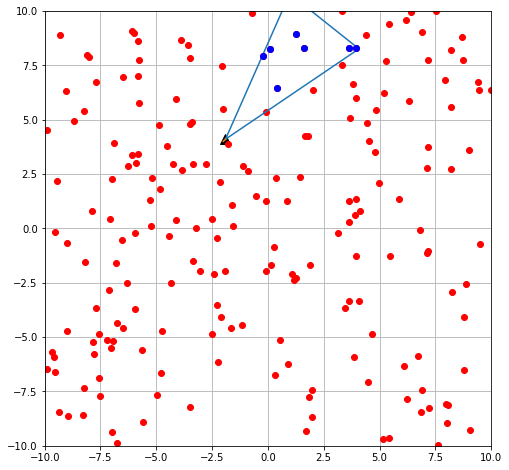

0.31898391246795654
Number of visible points in polygon: 8


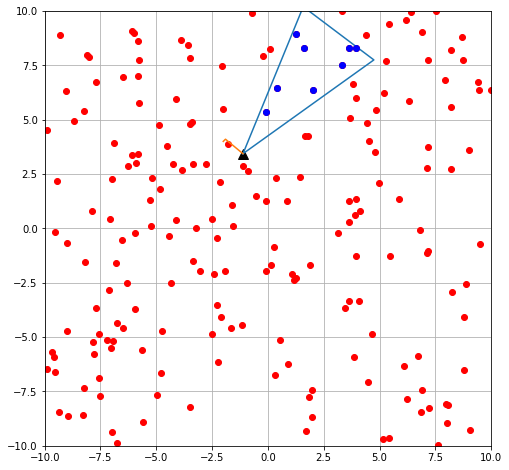

0.31733015179634094
Number of visible points in polygon: 8


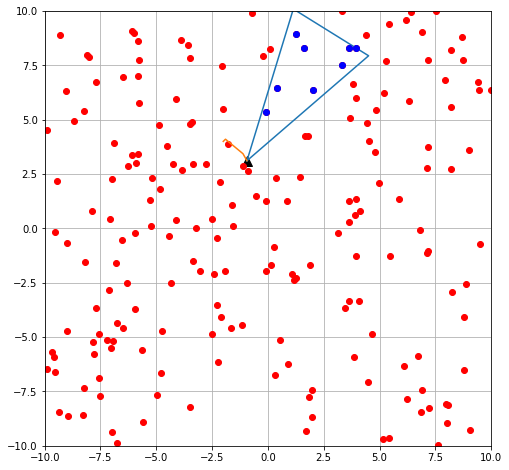

0.31764769554138184
Number of visible points in polygon: 8


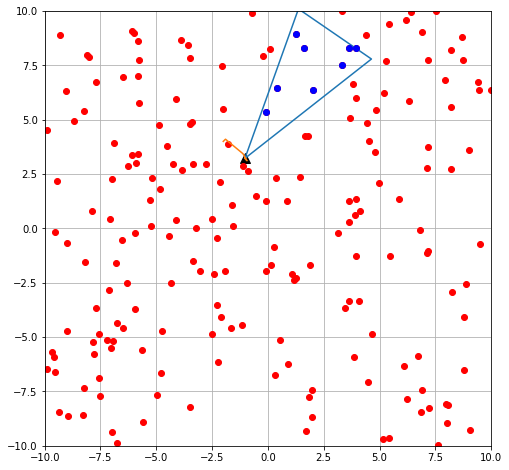

0.3364928364753723
Number of visible points in polygon: 8


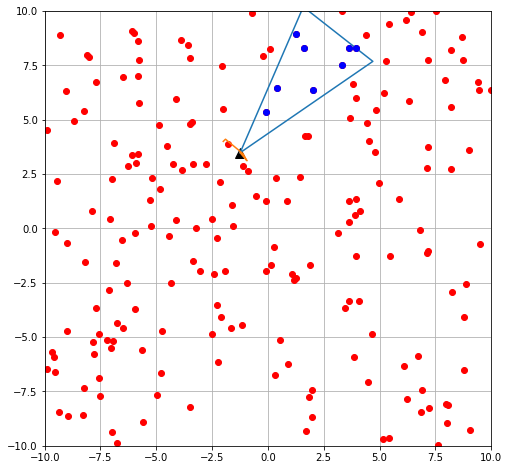

In [8]:
# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

traj = model.camera_xy_yaw.detach().cpu().unsqueeze(0)
# Run optimization loop
for i in tqdm(range(200)):
    optimizer.zero_grad()
    loss = model()
    loss.backward()
    optimizer.step()
    
    if i % 40 ==0:
        print(loss.item())
        state_visualizer(model.camera_xy_yaw.detach().cpu(), model.points.cpu())
        traj = torch.cat([traj, model.camera_xy_yaw.detach().cpu().unsqueeze(0)], dim=0)
        plt.plot(traj[:, 0], traj[:, 1])
        plt.show()

In [9]:
# x = 0.
# y = 0.
# yaw = -3.14/4
# for _ in range(10):
# #     x += 0.1
# #     y -= -0.1
#     yaw += 0.2
#     robot_xy_yaw = torch.tensor([x, y, yaw])
#     model = Model(pts, robot_xy_yaw[0], robot_xy_yaw[1], robot_xy_yaw[2])
#     loss = model()
#     print(loss)
#     state_visualizer(model)